## AUTOENCODER

In the notebook we will train an autoencoder to compress the information based on images of faces.

In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from skimage.transform import rescale, resize
from sklearn.model_selection import train_test_split

In [2]:
import keras, keras.layers as L, keras.backend as K
import keras_utils
import tensorflow as tf
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

Using TensorFlow backend.


## Training AUTOENCODER ON LFW dataset (Labeled faces in the wild)
After we train the autoencoder we will test it on the faces we have just extracted from our images.

In [3]:
from lfw_dataset import load_lfw_dataset
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

In [4]:
IMG_SHAPE

(32, 32, 3)

### Data preprocesing
In order to train the autoencoder we need to prepare the data by transforming it to a suitable format. We first scale the data to a range from 0 to 1 and than center it around zero by substracting 0.5.

original image pixels
[[ 99 113 138 156 161]
 [ 98 105 132 144 157]
 [ 93 110 125 134 144]
 [ 90 111 123 138 147]
 [ 86 106 117 133 146]]
centered image pixels
[[-0.1117647  -0.05686274  0.0411765   0.11176473  0.13137257]
 [-0.11568627 -0.08823529  0.01764709  0.06470591  0.1156863 ]
 [-0.13529411 -0.06862745 -0.00980392  0.02549022  0.06470591]
 [-0.14705881 -0.06470588 -0.01764706  0.0411765   0.07647061]
 [-0.16274509 -0.08431372 -0.04117647  0.02156866  0.07254905]]
transformed to 0-1 range image pixels
[[ 0.3882353   0.44313726  0.5411765   0.61176473  0.63137257]
 [ 0.38431373  0.41176471  0.51764709  0.56470591  0.6156863 ]
 [ 0.36470589  0.43137255  0.49019608  0.52549022  0.56470591]
 [ 0.35294119  0.43529412  0.48235294  0.5411765   0.57647061]
 [ 0.33725491  0.41568628  0.45882353  0.52156866  0.57254905]]


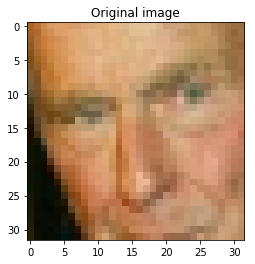

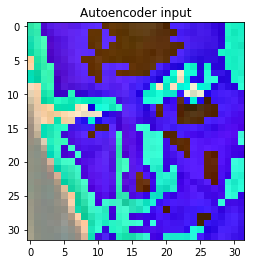

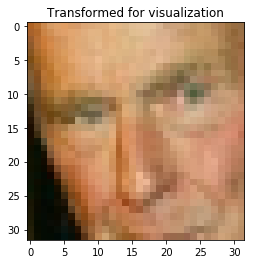

In [5]:
# INSPECT DATA PREPROCESSING
# original image pixels
print("original image pixels")
print(X[1,0:5,0:5,1])
plt.imshow(X[1])
plt.title("Original image")
# center images - for autoencoder training purposes
print("centered image pixels")
X = X.astype('float32') / 255.0 - 0.5
print(X[1,0:5,0:5,1])
plt.figure()
plt.imshow(X[1])
plt.title("Autoencoder input")
# transformed to 0-1 range - for visualization purposes
print("transformed to 0-1 range image pixels")
print(np.clip(X[1,0:5,0:5,1] + 0.5, 0, 1))
plt.figure()
plt.imshow(np.clip(X[1] + 0.5, 0, 1))
plt.title("Transformed for visualization")
# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


4013

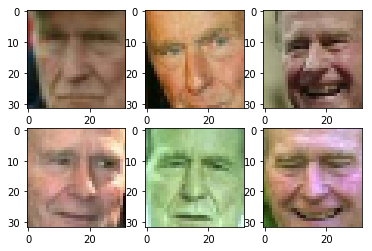

In [6]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
    
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

In [7]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


In [8]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(filters = 32, kernel_size=(3,3), 
                         padding="same", activation="elu"))
    encoder.add(L.MaxPool2D())
    encoder.add(L.Conv2D(filters = 64, kernel_size=(3,3), 
                         padding="same", activation="elu"))
    encoder.add(L.MaxPool2D())
    encoder.add(L.Conv2D(filters = 128, kernel_size=(3,3), 
                         padding="same", activation="elu"))
    encoder.add(L.MaxPool2D())
    encoder.add(L.Conv2D(filters = 256, kernel_size=(3,3), 
                         padding="same", activation="elu"))
    encoder.add(L.MaxPool2D())
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size)) 

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(2*2*256)) 
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), 
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), 
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), 
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), 
                                  strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [9]:
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
__________

reconstruction_mse
0.00551370778652


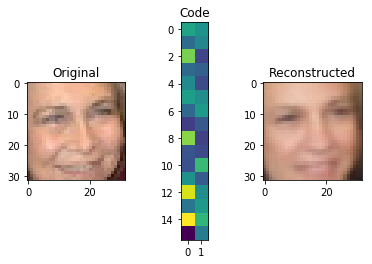

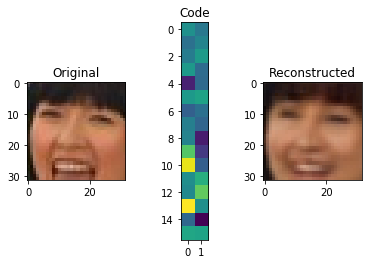

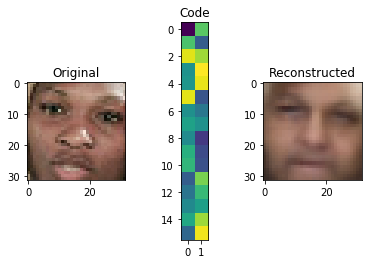

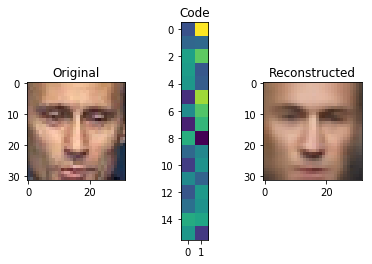

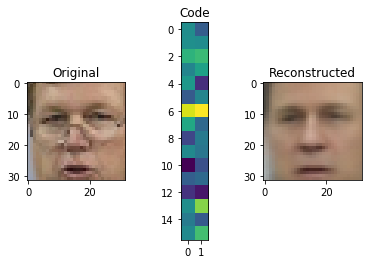

In [10]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print("reconstruction_mse")
print(autoencoder.evaluate(X_test, X_test, verbose=0))

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

## My data extraction

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
def find_face(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('../CNN part - old & new appraoch/Haar/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)
    return faces

def generate_results(path_in, people):
    result = list()
    person = list()
    name = list()
    location = list()
    for i in people:
        print(i)
        file_list = os.listdir(os.path.join(path_in,i))
        for j in file_list:
            image = plt.imread(os.path.join(path_in,i,j))
            faces = find_face(image)
            result.append(len(faces))
            person.append(i)
            name.append(j)
            location.append(faces)
    df = pd.DataFrame({"person":person, "image":name, "faces_count":result, "location":location})
    return(df)

def filter_only(results, face_count, top_n, person = None):
    df = results[results.faces_count == face_count]
    if person is not None:
        df = df[df.person == person]
    df = df.head(top_n)
    return df

In [12]:
path_in = "../CNN part - old & new appraoch/Test data"
people = ['cameron', 'holland', 'merkel', 'neither', 'obama', 'putin', 'trump']
results = generate_results(path_in, people)
results_filtered = filter_only(results, 1, 1000)

idx = [32 < i[0][3] < 40 for i in results_filtered.location]

results_filtered_small = results_filtered.iloc[idx]
results_filtered_small = results_filtered_small.reset_index()

cameron
holland
merkel
neither
obama
putin
trump


Below we will define a function that will prcess the pictures that we have (full body + surrounding) to a picture a a face only. To select the face we will use a HAAR detector. After this step we will resize all images to the same format. This function works in two modes one is used for visualization of steps described above the other one for transforming all the input data to desired format.

In [13]:
def extract_faces(path_in, path_out, faces_dictionary, mode, desired_size):
    for i in range(faces_dictionary.shape[0]):
        if not os.path.exists(os.path.join(path_out,faces_dictionary.loc[faces_dictionary.index[i], "person"])):
            os.makedirs(os.path.join(path_out,faces_dictionary.loc[faces_dictionary.index[i], "person"]))
        faces = faces_dictionary.loc[faces_dictionary.index[i], "location"]
        image = plt.imread(os.path.join(path_in,
                                        faces_dictionary.loc[faces_dictionary.index[i], "person"],
                                        faces_dictionary.loc[faces_dictionary.index[i], "image"]))
        for bbox in range(len(faces)):
            x,y,w,h = faces[bbox]
            image_cropped = image[y:(y+h),x:(x+w),:]
            image_resized = resize(image_cropped, desired_size, mode='constant')
            if mode == "plot":
                plt.figure()
                plt.imshow(image)
                plt.title("Original image")
                plt.figure()
                plt.imshow(image_cropped)
                plt.title("Cropped image - face only")
                plt.figure()
                plt.imshow(image_resized)
                plt.title("Resized face image")
            if mode == "transform":
                plt.imsave(os.path.join(path_out,
                                        faces_dictionary.loc[faces_dictionary.index[i], "person"],
                                        faces_dictionary.loc[faces_dictionary.index[i], "image"]), image_resized)

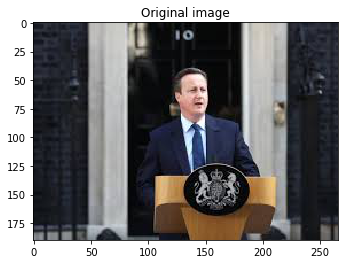

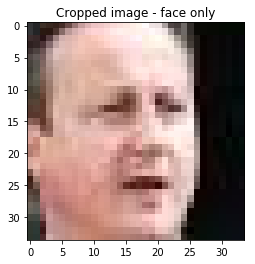

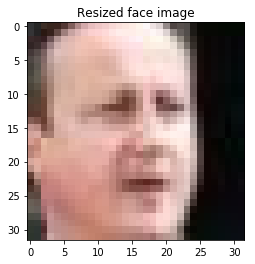

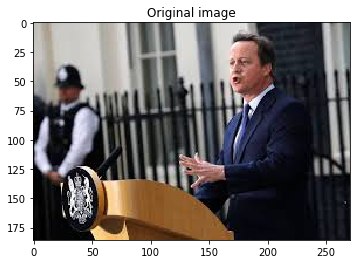

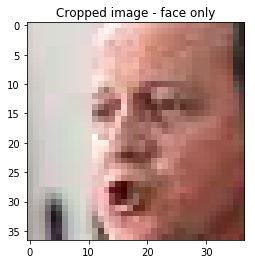

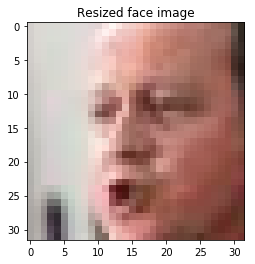

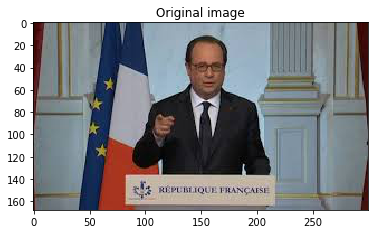

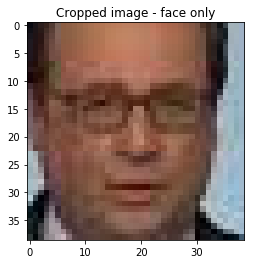

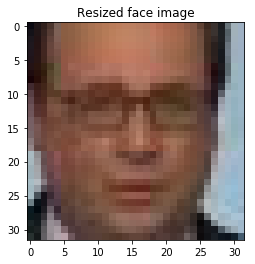

In [14]:
extract_faces("../CNN part - old & new appraoch/Test data",
              "faces",
              results_filtered_small.loc[0:2,], "plot", (32,32))

In [15]:
def load_all_images(path_in, people):
    images = list()
    for person in people:
        faces = os.listdir(os.path.join(path_in,person))
        for face in faces:
            img = plt.imread(os.path.join(path_in,person,face))
            images.append(img)
    return(np.array(images))

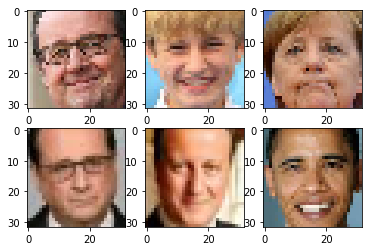

In [16]:
people = ['cameron', 'holland', 'merkel', 'neither', 'obama', 'putin', 'trump']
X = load_all_images(path_in="faces_all_32_32", people=people)
X = X[:,:,:,:3]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=1234)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[i])

## Testing autoencoder on my data

In [17]:
print("original image pixels")
print(X_test[1,0:5,0:5,1])

print("centered image pixels")
X_test = X_test.astype('float32') / 255.0 - 0.5
print(X_test[1,0:5,0:5,1])

original image pixels
[[186 205 210 223 202]
 [185 205 203 211 185]
 [172 191 194 198 196]
 [161 181 182 178 141]
 [170 154 186 122 130]]
centered image pixels
[[ 0.22941178  0.30392158  0.32352942  0.37450981  0.29215688]
 [ 0.22549021  0.30392158  0.29607844  0.32745099  0.22549021]
 [ 0.17450982  0.24901962  0.26078433  0.2764706   0.26862746]
 [ 0.13137257  0.20980394  0.21372551  0.19803923  0.0529412 ]
 [ 0.16666669  0.10392159  0.22941178 -0.02156863  0.00980395]]


reconstruction_mse
0.0124317696318


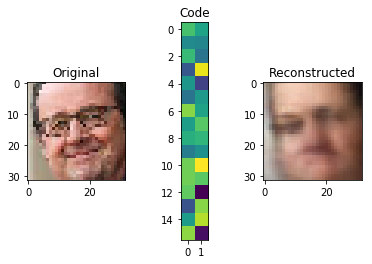

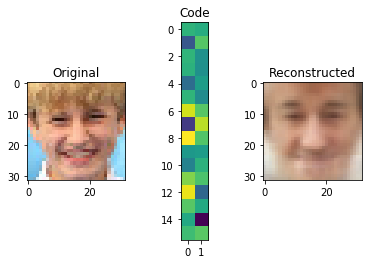

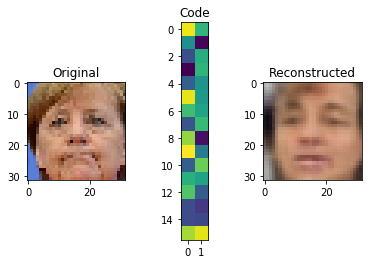

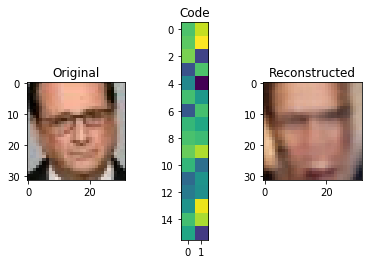

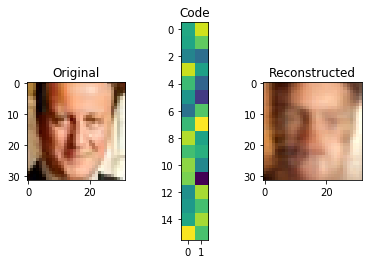

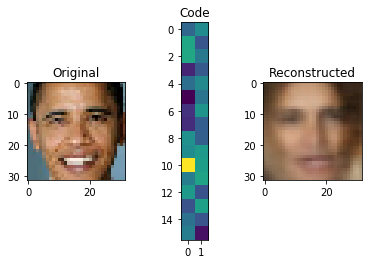

In [18]:
print("reconstruction_mse")
print(autoencoder.evaluate(X_test, X_test, verbose=0))

for i in range(6):
    img = X_test[i]
    visualize(img,encoder,decoder)

## AUTOENCODER trained with my data only

In [19]:
people = ['cameron', 'holland', 'merkel', 'neither', 'obama', 'putin', 'trump']
X = load_all_images(path_in="faces_all_48_48", people=people)
X = X[:,:,:,:3]

In [20]:
X = X.astype('float32') / 255.0 - 0.5
X_train, X_test = train_test_split(X, test_size=0.1, random_state=1234)

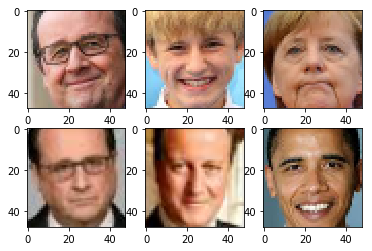

In [21]:
for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X_test[i])

In [22]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(filters = 32, kernel_size=(3,3), 
                         padding="same", activation="elu"))
    encoder.add(L.MaxPool2D())
    encoder.add(L.Conv2D(filters = 64, kernel_size=(3,3), 
                         padding="same", activation="elu"))
    encoder.add(L.MaxPool2D())
    encoder.add(L.Conv2D(filters = 128, kernel_size=(3,3), 
                         padding="same", activation="elu"))
    encoder.add(L.MaxPool2D())
    encoder.add(L.Conv2D(filters = 256, kernel_size=(3,3), 
                         padding="same", activation="elu"))
    encoder.add(L.MaxPool2D())
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size)) 

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(3*3*256)) 
    decoder.add(L.Reshape((3,3,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), 
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), 
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), 
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), 
                                  strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [24]:
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder((48,48,3), code_size=100)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
__________

reconstruction_mse
0.00762764715201


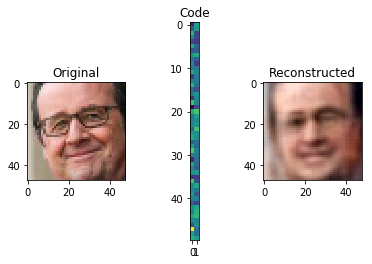

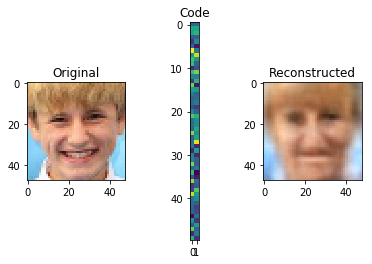

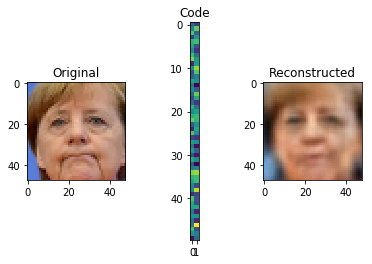

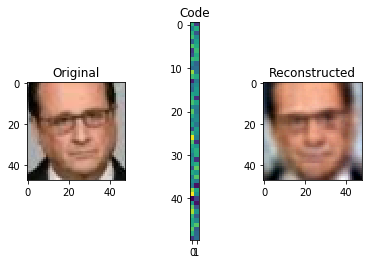

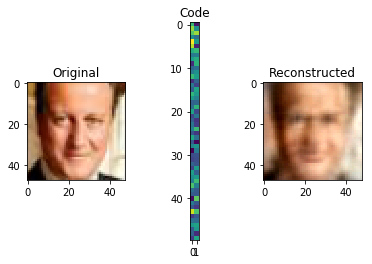

In [25]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder((48,48,3), code_size=100)
encoder.load_weights("my_encoder.h5")
decoder.load_weights("my_decoder.h5")

inp = L.Input((48,48,3))
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print("reconstruction_mse")
print(autoencoder.evaluate(X_test, X_test, verbose=0))

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)